In [2]:
import numpy as np
import pandas as pd
from math import tanh
import matplotlib.pyplot as plt
from itertools import product
from more_itertools import unique_everseen
from multiprocessing.dummy import Pool as ThreadPool

%matplotlib inline

/Users/kirill/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Project 4: Reinforcement Learning

Before we dive in, let me provide a short summary of `LearningAgent` instance initialization. You can induce a specific behavior by setting:

- `self.q_table_type`: either `default` (the agent will explore a 512 state-actions Q-Table) or `compact` (a shorter Q-Table with just 48 state-actions)


- `self.action_policy`: either `glie` (standard $\epsilon$-greedy policy) or `softmax` (experimental softmax action selection)


- `self.epsilon = 0` and `self.epsilon_decay = False` creates a greedy agent (max exploitation strategy); setting `self.epsilon = 1` and `self.epsilon_decay = False` creates an agent which always acts randomly (max exploration strategy)


- `self.alpha, self.gamma`: can be set in the class or defined as arguments from the command line: `python -m smartcab.agent 0.1 0.8`.


- or you can set all the parameters from command line: `self.alpha, self.gamma, self.epsilon, self.epsilon_decay, self.q_table_type, self.action_policy`, e.g.: `python -m smartcab.agent 1 1 1 False default glie`

**Important information about running this notebook**

This notebook can be run, but doing so will overwrite my variables and make some observations irrelevant.

**/!\\** I included several bash scripts in this notebook that generate log files. I made sure that none of them override my logs by default.

**/!\\** Also, I show an example of a grid search which generates even more log files. It may take some time and consume a bit of space on disk. Running this grid search will render my observations irrelevant, so please do it when you read the full report.

I'm not sure any of these log generation scripts will work on Microsoft Windows.

**/!\\** If you'd like to generate log files, please make sure to update `LearningAgent.run` method with a shorter delay and display turned off:
```
sim = Simulator(e, update_delay=0.001, display=False)
```

I see the basic idea of this project in learning about the exploration-exploitation dilemma and analyzing both extremes: random actions policy and greedy policy — and finding *an* (there can be more than one) optimal strategy in between.

## 1. Implement a basic driving agent

**Random actions of the agent as seen from the GUI simulator. Does the smartcab eventually make it to the destination? Are there any other interesting observations to note?**

Let's start with the description of the actions available to our agent:

$ A(s) = \{forward, left, right, None\}$, where *A* is the list of all actions available at the current state *s* of world.

Let $\pi$ be the policy which allows the agent choose the best next action. Policy $\pi(s,a)$ is the probability of taking action *a* when in state *s*. One of the simplest policies is a random choice among all actions without any other considerations: $\pi(s,a) = random_aA(s), \forall a \in A(s)$.

This policy is trivial, but it has a number of benefits:

1. It allows the agent explore the rules of the grid world, states and rewards. If we use this policy in combination with Q-Learning, we can obtain a reliable Q-Table (provided we let the agent explore the states and actions long enough). Afterwards, we change the policy to greedy and start exploiting instead of exploring.

2. The agent has a chance explore all the available state-actions pairs and it can reach destination.

3. This method can be used further as a part of $\epsilon$-greedy exploration policy to optimize the amount of visited states: $\epsilon \in [0,1]$. Random choice policy is the extreme case when $\epsilon=1$.

If we just run the simulator and observe (setting `enforce_deadline` to `False`), we may notice a number of trivial facts about the smartcab:

1. The agent doesn't learn to react properly on inputs.

2. It may or may not reach destination (it doesn't for the majority of the trials).

3. It usually takes a penalty rather than a reward.

4. For most of the cases, the intersection is clear from other cars.

To analyze the agent's behavior deeper and eliminate the possibility of spotting false patterns, we set `enforce_deadline` to `True`, turn off the GUI rendering and run the code with logging. As for now, $\alpha$ and $\gamma$ can be set to any valid variable, e.g. (1,1).

In [3]:
%%bash
# remove "__custom_run" from the filename below to overwrite logs for plots

for i in 0 1 2
do
    python -m smartcab.agent 1 1 1 False default glie > data.txt
    python log_parser.py data.txt $i >> 512_glie_random_sample__custom_run.tsv
done

We also need to prepare the charts we'll use throughout the project. To make reliable conclusions, I always run at least three simulations (each consists of 100 trials): there will be three plots side by side.

A basic information is provided by plotting the total reward per each trial. We also add a trendline to see average values and mark successful trials (when the agent reaches the target) with blue dots.

In [9]:
def plot_rewards(file, sims=None, start_from_trial=0):
    moves = pd.read_csv(file, sep='\t')

    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    fig.set_size_inches(16,5)

    for ax, sim in zip([ax1, ax2, ax3], sims or range(0,3)):
        moves_sim = moves[moves['simulation'] == sim]
        reward = moves_sim['total_reward']

        # Trendline for total reward per trial
        c = np.polyfit(moves_sim['trial'], reward, 2)
        trendline = [c[0] * x * x + c[1] * x + c[2] for x in range(0,100)]

        reaches = moves_sim[moves_sim['goal_reached'] == True]
        
        ax.set_xlim(0,100)
        ax.set_xlabel('Trial')
        ax.set_ylabel('Total Reward after Trial')
        ax.set_title('Total Reward per Trial, sim #{}'.format(sim))
        ax.plot(moves_sim['trial'], reward, label='Rewards')
        ax.plot(range(0,100), trendline, label='Trend')
        ax.scatter(reaches['trial'], [ax.get_ylim()[1]] * len(reaches['goal_reached']), label='Goal Reached')
        ax.legend(loc=4)
        successful_reaches = moves_sim[moves_sim.trial >= start_from_trial].groupby('goal_reached').count().trial
        print 'Goal reached since trial {}, sim #{}: {}\n'.format(start_from_trial, sim, successful_reaches / (100 - start_from_trial))

To see how the agent discovers new Q-Table state-actions, we also plot visited state-actions. We include two charts in one plot: states visited and state-actions visited. A modification of this plot also shows the maximum amount of states and state-actions (dash lines).

In [3]:
def plot_visited_state_actions(file, take=4, legend_loc=2, states=None, sims=None):
    
    def compress_state_actions(state_action):
        return list(unique_everseen([str(k[:take]) for k in map(list, state_action.keys())]))
    
    moves = pd.read_csv(file, sep='\t')

    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    fig.set_size_inches(16,3)

    for ax, sim in zip([ax1, ax2, ax3], sims or range(0,3)):
        moves_sim = moves[moves['simulation'] == sim]
        
        visited_state_actions = moves_sim['qtable'].apply(lambda x: len(eval(x).keys()))
        visited_states = moves_sim['qtable'].apply(lambda x: len(compress_state_actions(eval(x))))
        
        ax.set_xlim(0,100)
        ax.set_xlabel('Trial')
        ax.set_ylabel('Elements')
        ax.set_title('Unique Q-Table Elements Visited, sim #{}'.format(sim))
        ax.plot(moves_sim['trial'], visited_state_actions, 'm-', label='State-actions')
        ax.plot(moves_sim['trial'], visited_states, 'b-', label='States')
        if states:
            state_actions = states * 4
            ax.set_ylim(0, state_actions * 1.1)
            ax.plot([0,100],[states,states], 'b--')
            ax.plot([0,100],[state_actions,state_actions], 'm--')
            
        ax.legend(loc=legend_loc)

Finally, we'd like to see how many errors the agent makes from trial to trial:

In [3]:
def plot_errors(file):
    moves = pd.read_csv(file, sep='\t')

    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    fig.set_size_inches(16,3)

    for ax, sim in zip([ax1, ax2, ax3], range(0,3)):
        moves_sim = moves[moves['simulation'] == sim]
        
        errors = moves_sim['errors']
        
        ax.set_xlim(0,100)
        ax.set_xlabel('Trial')
        ax.set_ylabel('Errors')
        ax.set_title('Errors, sim #{}'.format(sim))
        ax.plot(moves_sim['trial'], errors, 'm-', label='Errors')
        ax.legend()

Random action policy yields the following rewards per trial and Q-Table state-actions explored:

Goal reached since trial 0, sim #0: goal_reached
False    0.93
True     0.07
Name: trial, dtype: float64

Goal reached since trial 0, sim #1: goal_reached
False    0.83
True     0.17
Name: trial, dtype: float64

Goal reached since trial 0, sim #2: goal_reached
False    0.82
True     0.18
Name: trial, dtype: float64



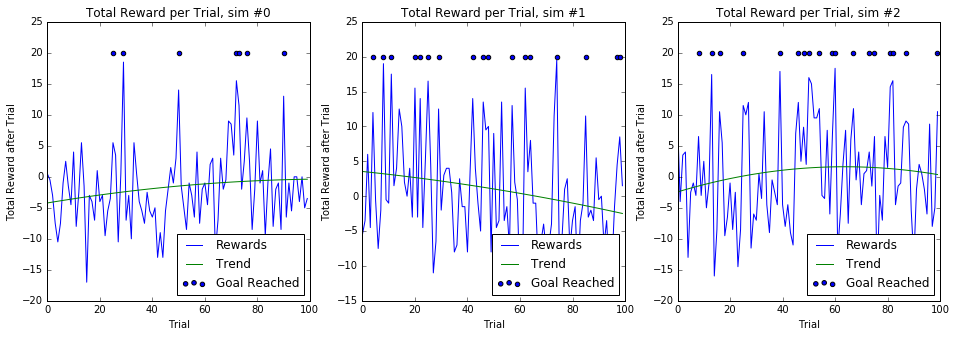

In [12]:
plot_rewards('512_glie_random_sample.tsv')

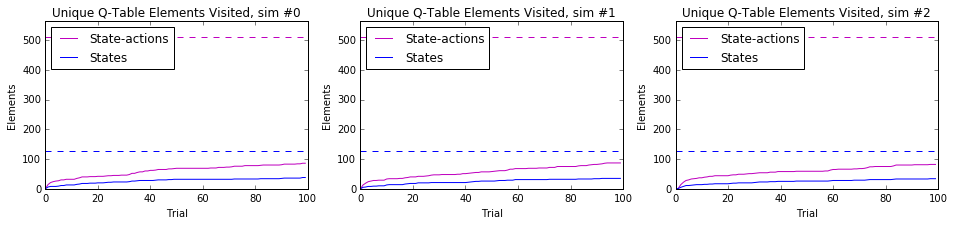

In [9]:
plot_visited_state_actions('512_glie_random_sample.tsv', states=128)

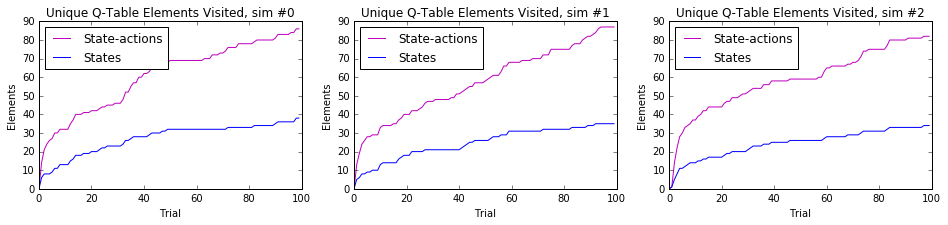

In [10]:
plot_visited_state_actions('512_glie_random_sample.tsv')

Some observations from these plots:

1. The trendline is flat and it is close to zero. This conclusion may be counterintuitive for a person who just looks at simulator. The agent gets many penalties due to the chaotic behavior and since most of the moves are penalized (only the correct one is rewarded).

2. The peaks in total reward per trial are mostly due to successful target reach.

3. Total reward per trial is very unstable and we do expect that.

4. The agent reaches the target relatively often. Within these 3 simulations, 14% of trials were successful (agents reached the goal within a deadline). I ran another set of simulations (25 simulations) and got an average 16.8% of successful trials.

5. **States visited:** we haven't yet defined our Q-Table, but, anticipating this, our Q-Table will consist of 512 state-actions pairs. Using a random action selection, agents typically explore about 35 states (27% of 128 states) and up to 90 different state-action pairs (17.5% of 512 pairs), they explore 90/35 = 2.5 (sometimes, up to 3) actions per state on average. The agents fail to visit the whole Q-Table even in "exploration mode".

6. We see a spike in state-actions visited on the first trials, the growth slows down later on. There seem to be very well-known states the agent visits frequently and very rare states. Looking at logs (sim \#0, trial \#99), we see a handful of frequent state-actions (`('right', 'green', None, None, 'left'): 172,  ('right', 'red', None, None, 'right'): 185`, etc) and a long tail of once or twice visited state-actions. Unknown state-actions are not even represented in logs.

7. By choosing a specific action selection policy, we may increase the amount of actions per state to 4 (35 \* 4 = 140 state-actions), but this won't help us visit more distinct states. Thus, **we can't guarantee zero errors and perfect learning** even with the best action selection policy and on the final trial. This can be fixed by allowing the agent train much more or by merging similar states into one. The latter way won't provide perfect learning either, but it will be discussed later in the project.

To make sure the actions taken are indeed random, we plot a bar chart with all actions:

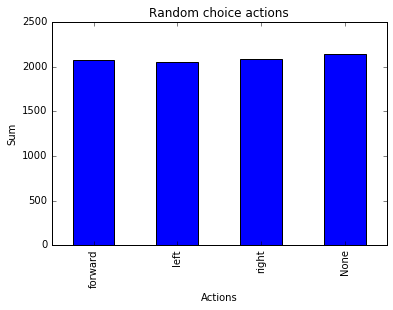

In [11]:
rand_moves = pd.read_csv('512_glie_random_sample.tsv', sep='\t')
rand_moves_sum = rand_moves[['forward', 'left', 'right', 'None']].sum()
plt.figure()
rand_moves_sum.plot.bar(); plt.xlabel('Actions'); plt.ylabel('Sum'); plt.title('Random choice actions')

As we see, the agent doesn't prefer any move to another.

## 2. Inform the Driving Agent

**What states have you identified that are appropriate for modeling the smartcab and environment? Why do you believe each of these states to be appropriate for this problem?**

Our goal is to figure out the minimum amount of variables which comprehensively describe each state our agent may find itself in. 

Why figuring out the minimum comprehensive set of inputs is important? It's known [[Koenig and Simmons, 1993](https://www.aaai.org/Papers/AAAI/1993/AAAI93-016.pdf)] that the 1-step Q-Learning is a $O(en)$ problem in general case. In the case of no duplicate actions, the complexity becomes polynomial $O(n^3)$, but it's still computationally expensive. Also (as we briefly touched upon in the previous section), an agent with a larger Q-Table will more likely fail visiting the whole (or even the majority) Q-Table and will make more errors in the long run.

Q-Learning can be used to find an optimal action selection policy for any given (finite) Markov decision process (MDP). As we know from lectures, the main assumption of MDP is that the next state only depends on the decision made by evaluating variables of the _current_ state and doesn't depend on history or other states. That's why we need to make sure our state incorporates everything needed to find and apply an optimal policy.

Informally speaking, the agent should be capable of doing two things: it should follow planner's orders and it should learn to postpone that move due to traffic conditions. Planner's orders can be represented by `self.planner` instance variable in `Agent` class. The smartcab senses current intersection situation using `self.inputs` variable.

**Variables I excluded from the state description:**

1\. **Deadline**. The agent is not supposed to change its behavior when the time is running out. Smartcab has no information to understand whether it is close to target. In this sense, deadline is useless for our agent.

2\. **Right traffic**. This is a redundant input as the state of traffic light provides enough data. The mechanics of the world is such that the green traffic light for our agent means red for a smartcab to the right. Depending on the  light signal, there are the following actions the smartcab can make:

* Red light: do not move or turn right yielding to our agent. We are safe to move.

* Green light: move (almost) in any direction. Our smartcab is allowed either not to make a move, or turn right. Since the agent comes from the right, the collision is not possible.

3\.  Anything (location, heading, position of all cars or the state of all traffic lights) that is not directly visible to the smartcab. This information is not available to the agent and it should not be used to model the state.

Now we can gather state components:

* Next waypoint from the route planner, describing the direction to move to: `self.planner = RoutePlanner(self.env, self)`.

* A traffic light at the current intersection: `self.traffic_light = self.inputs['light']`.

* The direction of oncoming traffic at intersection : `self.oncoming = self.inputs['oncoming']`.

* The direction of traffic from the left at intersection: `self.left = self.inputs['left']`.

Each component has several values:

* $ next\_waypoint = \left \{ None, Right, Left, Forward \right \} $
* $ light\_state = \left \{ Red, Green \right \} $
* $ oncoming\_traffic = \left \{ None, Left, Right, Forward \right \} $
* $ left\_traffic = \left \{ None, Left, Right, Forward \right \} $

**How many states in total exist for the smartcab in this environment? Does this number seem reasonable given that the goal of Q-Learning is to learn and make informed decisions about each state? Why or why not?**

The total amount of states is $ 4 \cdot 2 \cdot 4 \cdot 4 = 128 $. On each state, we can make one of four actions $A(s)$. The size of Q-Table with these state-action combinations is $ 128 \cdot 4 = 512$. This can be optimized even further, but we keep this Q-Table for now.

As we discussed, the agent will not be able to visit all 128 states and 512 combinations even once, let alone several times. This doesn't guarantee a perfect learning and our agent will be making occasional mistakes. Though, I suppose, such states are rarely occurring and the learning can still be successful.

## 3. Implement Q-Learning

To implement Q-Learning, I use the following method (which is [referred](https://discussions.udacity.com/t/please-someone-clear-up-a-couple-of-points-to-me/45365/2) as the method \#2 on forum):

1. **Initialize a Q-Table and set values in it to 0.**

2. **Do the following once during a simulation:**
    - Step 1: Sense the environment, prepare the state and append it to the `state_history` list.
    - Step 2: Using a policy $ \pi $, choose the best next action.
    - Step 3: Make this action and append it to the `action_history` list.
    - Step 4: Observe a reward/penalty received and append it to the `reward_history` list.

3. **Repeat on each iteration:**
    - Step 1: Sense the changed environment, prepare the new state, append it to the `state_history` list.
    - Step 2: Find the best next action using $ \pi $.
    - Step 3: Update the Q-Table.
    - Step 4: Make the best next action, receive a reward or penalty, update `action_history` and `reward_history` lists.

#### Q-Learning function:

$ Q(s,a) = R(s) + \gamma \sum_{s'}^{ }T(s,a,s')\max_{a'} Q(s',a') $, where:

- $Q(s,a)$: long-term reward for taking action *a* in state *s*,
- $R(s)$: immediate reward for arrival to state *s*,
- $\gamma$: discount rate,
- $T(s,a,s')$: transition function,
- $\max_{a'} Q(s',a')$: the Q value of the best next move ($a'$) in state ($s'$).



To estimate the Q value from transitions and to update the Q-Table, we need an iterative algorithm:

$ Q(s,a) \leftarrow  Q(s,a) + \alpha \left [ r + \gamma max_{a'}Q(s',a') - Q(s,a) \right ] $ 

$ Q(s,a) \leftarrow  (1-\alpha) \cdot Q(s,a) + \alpha \left [ r + \gamma max_{a'}Q(s',a') \right ] $, where $\alpha$ is the learning rate.

### Policy function:

We switch to a very different action selection policy, always choosing the best next move instead of picking it randomly. Such actions are called *greedy actions* and the policy we use is *maximum exploitation* policy:

$ \pi(s) = argmax_a Q(s,a), \forall a \in A(s) $

If all $A(s')$ provide the exact same Q values (e.g. at the beginning of trial \#1), the best action is chosen randomly.

Unfortunately, this policy is unreliable. The main problem is that the learning is very limited and heavily dependent on initialization and initial states. As we'll see soon, our agent can stuck in local minima.

We don't know the optimal values of $\alpha$ and $\gamma$, so we just take values that look reasonable:

- Alpha = 0.3 (the agent keeps 70% of its current "experience" when updating state-action)
- Gamma = 0.7 (the agent prefers future rewards over the immediate gain).

Let's run simulations, log outputs and plot two sets of charts:

- Total reward per trial chart 

- Visited states and state-actions chart.

Then we compare the results with similar charts built for a randomly acting agent.

In [103]:
%%bash
# remove "__custom_run" from the filename to overwrite logs for plots
# to get a greedy behavior, set self.epsilon = 0; self.epsilon_decay = False

for i in 0 1 2
do
    python -m smartcab.agent 0.3 0.7 0 False default glie > data.txt
    python log_parser.py data.txt $i >> 512_greedy_out__custom_run.tsv
done

Goal Reached, sim #0: goal_reached
False    0.02
True     0.98
Name: trial, dtype: float64

Goal Reached, sim #1: goal_reached
False    0.61
True     0.39
Name: trial, dtype: float64

Goal Reached, sim #2: goal_reached
False    0.06
True     0.94
Name: trial, dtype: float64

Goal Reached, avg.: goal_reached
False    0.23
True     0.77
Name: trial, dtype: float64


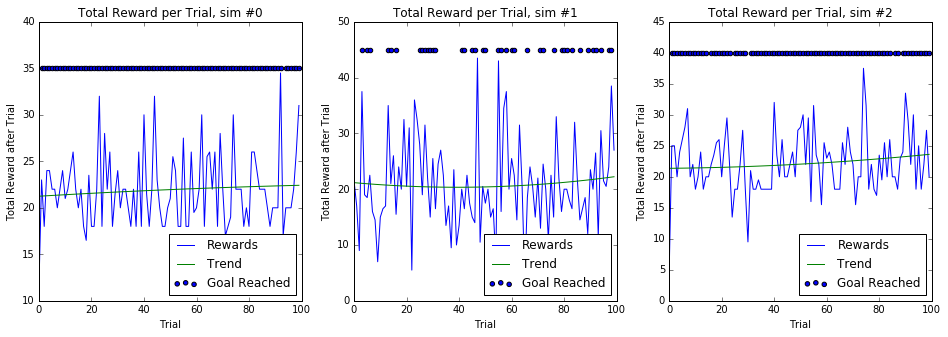

In [12]:
plot_rewards('512_greedy_out.tsv')

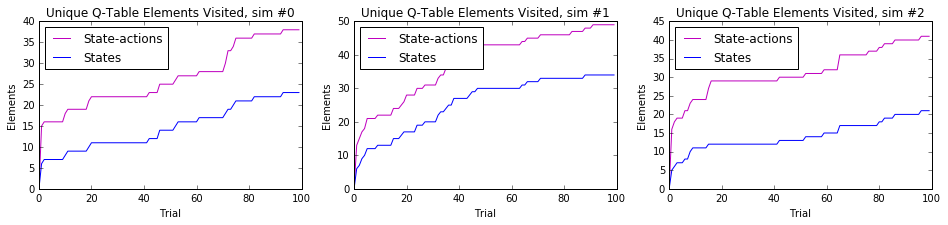

In [13]:
plot_visited_state_actions('512_greedy_out.tsv')

**What changes do you notice in the agent's behavior when compared to the basic driving agent when random actions were always taken? Why is this behavior occurring?**

#### Simulator

If we just look at the simulator, we'll see all the good indicators our agent's supposed to have (compared to the randomly acting agent):

- It gets mostly positive rewards, which means it does learn the traffic rules to some extent.

- Most of the time, it reaches the target.

We may or may not notice a weird behavior (like a right-move preference strategy) and we definitely don't see the big picture of agent's moves. It's basically impossible to optimize the agent using the simulator only. Fortunately, we have logging ang plotting capabilities that we will use to analyze the agent further.

#### State-actions analysis

1. The first thing we see is a substantial decrease in state-actions visited (instead of 90, now agents visit about 40-50). Now we know that by picking a specific $\epsilon$ we can vary this value from 40 to 90.

2. The agent sees less states (25-30 instead of 35-40): for some reason, an action selection policy influences _how many_ states an agent visits.

3. The state-actions to states ratio is about 1.3-1.6, which is considerably worse than in max exploration strategy. This agent prefers not to try new actions when finds itself in a state it visited before.

#### Total reward per trial analysis

1. The plot on the left shows good total rewards per trial (TRT): the lows are about 17, goal reach percentage is 98%. There are no significant drops in agent's performance (below 17) — we can use this agent as a model for a good learner so far.

2. The right plot is worse, but still usable: we see one TRT < 12 and the lows hitting 15. Average goal reach is 94%.

3. The plot in the middle is the worst of three: TRT is chaotic with the lows about 10. This makes the agent unreliable and it reaches goals in just 39% of the trials. This agent also has the worst state-actions to states ratio.

To get more insights about the choices agents made, we look at the moves patterns:

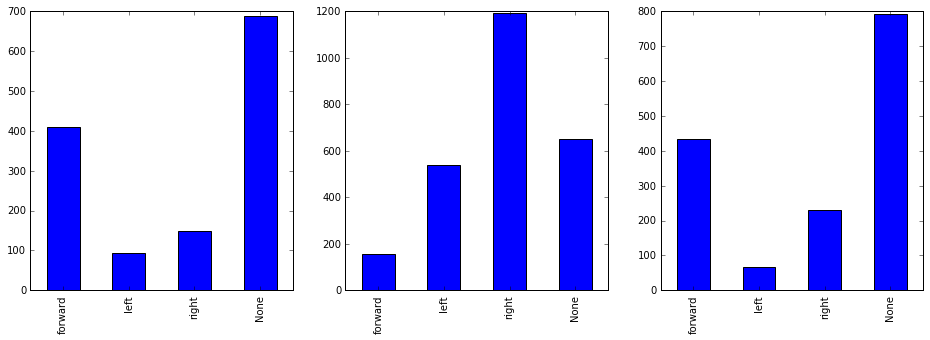

In [14]:
q_moves = pd.read_csv('512_greedy_out.tsv', sep='\t')

fig, (ax1, ax2, ax3) = plt.subplots(1,3)

fig.set_size_inches(16,5)
for ax, sim in zip([ax1, ax2, ax3], range(0,3)):
    moves_sim = q_moves[q_moves['simulation'] == sim]
    q_moves_sum = moves_sim[['forward', 'left', 'right', 'None']].sum()
    q_moves_sum.plot.bar(ax=ax)

Left and the right plots show a correctly learned behavior. We do expect the agent to make a couple of turns, but mostly it should either move forward to the target, or stand still to follow the traffic rules. I'd prefer the pattern in the left ( `left < right << forward < None`) due to the good agent's performance as shown earlier.

The agent on the right plot seem to prefer the right move more than necessary. This is a very addictive move, but in this example the agent is only slightly affected by this behavior.

The middle plot shows the worst moves preference of these three agents: `forward << left < None < right`. We see abnormally high amount of right moves (right-move preference strategy) and very few forward moves. 

Actually, this right-turn preference is very malignant as well as the current Q-Learning implementation with a greedy policy. When we run more simulations, some more failed learners appear. They are so notable that I decided to show some of them.

#### Failed learners and local optima

Such agents can reveal us some non-trivial properties of the simulated world, the rules and biases agents can fall into, so it's a good idea to look closer of them. 

I ran 25 simulations and got about 5 badly failed behaviors. All of them are characterized by a very chaotic performance (TRT) from one trial to another and none of them have improved till the end of their simulation. Though chaotic, TRT is usually positive averaging about 20.

We examine 3 of such learners in the plot below:

In [ ]:
# remove "__custom_run" from the filename to overwrite logs for plots

for i in range(25):
    !python -m smartcab.agent 0.3 0.7 0 False default glie > data.txt
    !python log_parser.py data.txt {i} >> 512_25s_greedy_out__custom_run.tsv

Goal Reached, sim #2: goal_reached
False    0.13
True     0.87
Name: trial, dtype: float64

Goal Reached, sim #10: goal_reached
False    0.31
True     0.69
Name: trial, dtype: float64

Goal Reached, sim #20: goal_reached
False    0.26
True     0.74
Name: trial, dtype: float64

Goal Reached, avg.: goal_reached
False    0.0868
True     0.9132
Name: trial, dtype: float64


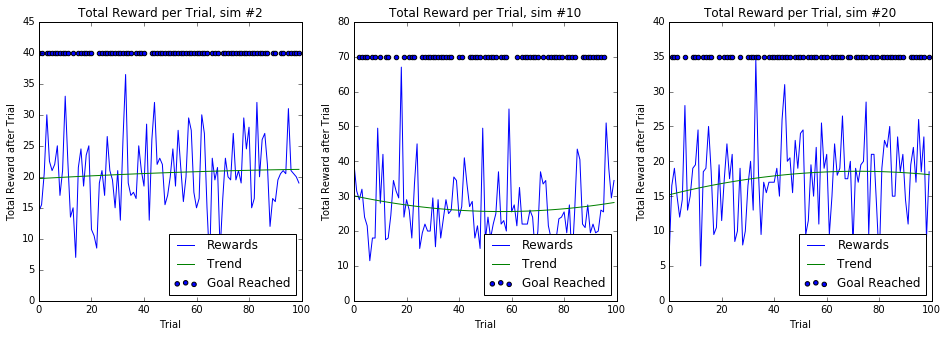

In [17]:
q_moves = pd.read_csv('512_25s_greedy_out.tsv', sep='\t')

plot_rewards('512_25s_greedy_out.tsv', sims=[2,10,20])

Moves summary reveals strategies these agents follow:

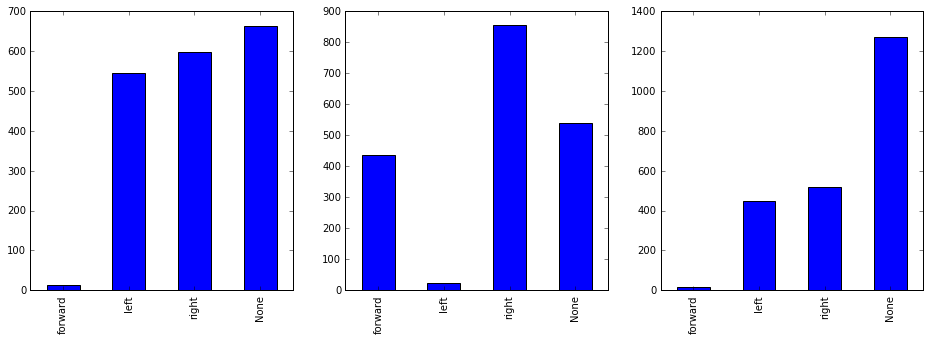

In [16]:
q_moves = pd.read_csv('512_25s_greedy_out.tsv', sep='\t')

fig, (ax1, ax2, ax3) = plt.subplots(1,3)

fig.set_size_inches(16,5)
for ax, sim in zip([ax1, ax2, ax3], [2,10,20]):
    moves_sim = q_moves[q_moves['simulation'] == sim]
    q_moves_sum = moves_sim[['forward', 'left', 'right', 'None']].sum()
    q_moves_sum.plot.bar(ax=ax)

**Left learner**: no-forward move strategy. This agent takes any move except for moving forward. While very chaotic, this agent somehow manages to reach its goal 87% of the time. Indeed, a forward move can be substitued with several left and right moves.

**Middle learner:** right-move preference strategy and the fear of the left move. This is a combination of two features:

- right-move preference: making the right move only provides a positive reward in the long run. Once made, this right move becomes addictive and the agent prefers it to other moves. Right move is the safest: it can be made on red and green light. The only state with a severe penalty is when there is a car from the left moving straight (a rare case). But most of the time, our agent receives either +2.0 or -0.5.

- fear of the left move: if made wrong, the left move is penalized more often. The left move is only allowed 1) if the light is green, 2) if there's no oncoming traffic moving straight. It's a stricter condition comparing to a mostly safe to make the right turn move.

**Right learner:** a fearful agent that prefers to stand still rather than make a move. Have it make a move, it moves to the right (the safer move) half of the time.

All of these learners have stuck in a local optima and it _is_ a problem for learning:

- The agent doesn't care to reach the goal
- The agent never maximizes its reward
- The agent is very **biased**, shortsighted and has no stimula to learn.

We need to somehow balance an exploration behavior, when an agent makes a lot of mistakes intentionally, and an exploitation strategy, when an agent can fall into biases described above.

### 3. Improve the Q-Learning Driving Agent

We miss one of the most important issues regarding the agent: how to measure its performance and compare one to another. We are now going to pick such a metric and use it further.

#### Regarding the key performance indicators for the agent

As we already know, the perfect agent follows the planner as well as traffic rules. This means that the route itself is set explicitly and not following the planner always leads to penalties. The only choice our agent has is to decide whether to move or to stay at the current position.

Another thing we should keep in mind is that the agent may become hesitant and skip safe moves — and thus miss a deadline. To ensure this does not happen to our agent, we should indeed analyze the percentage of target reaches and state-actions count of the final agent.

This leads us to the following indicators:

1. Amount of trials our agent successfully reaches the goal. Let's not make this metric complicated and just use a simple ratio `successes / all_trials`. This metric should be used with another one, because it alone does not describe how well an agent performs. To optimize this metric, an agent should never explore any states and must blindly follow the `next_waypoint`. This is not what we want from it.

2. Amount of errors per trial. We may also keep track of the amount of penalties per trial. We'll use an absolute value of errors per trial.

Also, the deadline is hidden from the agent (and the reward for reaching the target is fixed). It greatly simplifies the decisions of our agent. If the agent had known the deadline, there could have been the whole varieties of new complex strategies involving it.

We are free from these complexities and are basically required to train the agent to obey the traffic rules. If our agent is trained to follow the planner as well as to obey the traffic rules, we 1) get a good overall reward for a trial, 2) successfully reach the target in a reasonable time.

Thus, we can optimize on the agent's long-run error rate. The next stage is to find several agents with low error rates and pick the one which consistently reaches the goal.

There is a catch: we want our agent to make as many mistakes as it needs to in the first trials, but expect it to move correctly later on. As we have seen, agents, that failed to learn, still make a substantial amount of errors after dozens of trials. Hence, we should punish agent for making errors in later trials more than during the start of learning.

#### Formula for LRE

Let's get more formal. Let $P(t)$ be the function for punishing later stage errors: 

$ P(t) = \tanh(\frac{t^2}{100}) $, where t is the number of the current trial.

The choice of hypertangent is simple: we don't want to punish the agent hard for mistakes during the first trials, but a wrong move after trial \#20 should be considered an error.

The long-run error for a single simulation can be defined: 

$ LRE_s = \sum_{t=0}^{99}P(t) \cdot e_t $, where *s* is a number of the current simulation and $e_t$ is the number of errors at the end of trial *t*.

One simulation is not enough (as we have seen with the biased agent) and we need to run simulation several times to capture the pattern. Let's run simulation at least three times and calculate the average error among simulations *s*:

$ LRE = avg(LRE_s), s = 0,1,2 $

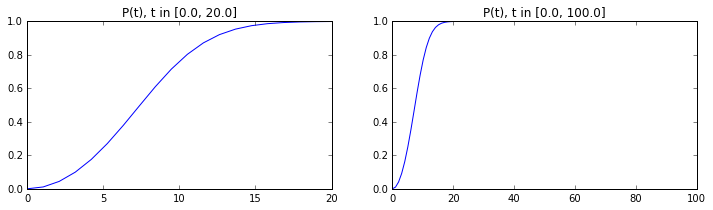

In [7]:
t1 = np.linspace(0.0, 20, 20)
t2 = np.linspace(0.0, 100.0, 100)

fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,3)
for ax, t in zip([ax1, ax2], [t1, t2]):
    ax.set_title('P(t), t in [{}, {}]'.format(t[0],t[-1]))
    ax.plot(t,[tanh(x_**2/100) for x_ in t])

#### Optimizations of Q-Learning

After finding the long-term metric to optimize upon, we need to think over the ideas for our optimization. Here they are:

1. Optimization of the Q-Table size. Our current Q-Table consists of 512 different state-action pairs. As we know, the majority of them were either never visited or visited only once. To ensure the agent learned successfully, we need to maximize the percentage of state-actions visited.

2. Parameters optimization. Alpha and gamma are the hyperparameters of this model as they are given to this model from the outside. We can use a grid search-like iterative approach trying different combinations of hyperparameters and picking the best performing one.

3. Choosing a different kind of an algorithm. We are going to use GLIE (greedy learning + infinite exploration) action selection strategy and we know it chooses to explore a random action, even if it's already been explored. As an alternative, we can try a different action selection algorithm.

#### Optimization of the Q-Table size

Our Q-Table currently consists of 128 states, each with 4 possible actions, resulting in 512 different combinations. 

* $ A (next\_waypoint) = \left \{ None, Right, Left, Forward \right \} $
* $ A (light\_state) = \left \{ Red, Green \right \} $
* $ A (oncoming\_traffic) = \left \{ None, Left, Right, Forward \right \} $
* $ A (left\_traffic) = \left \{ None, Left, Right, Forward \right \} $

A minor improvement would be to remove A(next_waypoint) = None. This value may only happen if we reach the target. But in this case, our agent doesn't have to make any decision. Removing this value helps us reduce the Q-Table to 3 \* 2 \* 4 \* 4 \* 4 = 384 state-action pairs.

The second way to optimize the Q-Table, which I find controversial (but it's still within the rules of the project since we don't manually program the agent) is below. 

We have two types of state variables: 1) a waypoint from the planner, 2) the situation on an intersection. Let's discuss each of these two:

* `next_waypoint` is an independent variable and there's no way to include it as a part of anything else.

* variables describing the situation on an intersection, can be reviewed. Can we use less than three variables to describe it?

The project description has the answer we are looking for:
> On a green light, a left turn is permitted if there is no oncoming traffic making a right turn or coming straight through the intersection.

> On a red light, a right turn is permitted if no oncoming traffic is approaching from your left through the intersection.

We can formalize this description in the following pseudocode for describing the states:

```
if light == "green" and oncoming_traffic in [None, "left"]: green_safe_to_move
else if light == "green" and oncoming_traffic in ["right", "forward"]: green_yield_oncoming
  
if light == "red" and left_traffic == "forward": red_yield
else if light == "red" and left_traffic in [None, "left", "right"]: red_safe_to_move_right
```  

Writing down the new combined states, we have only four intersection values: `green_safe_to_move, green_yield_oncoming, red_safe_to_move_right, red_yield` and three planner values. This is a good optimization, cutting down from initial 128 states to 3 * 4 = 12 states.

This leads us to a new Q-Table with 12 * 4 = 48 state-action pairs which is 10.7 times smaller than the original Q-Table.

Further on, I'll keep using my default Q-Table with 512 values along with a smaller Q-Table. Also, we should keep in mind that we really have 384 (not 512) state-actions, because all the states with `next_waypoint` set to `None` are either unreachable or useless.

**Smaller Q-Table and the choice of $\epsilon$ decay rate**

Let's plot visited state-actions plot for a smaller Q-Table, starting with a greedy strategy:

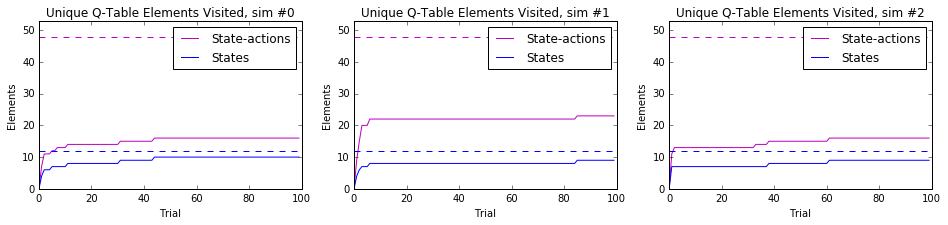

In [17]:
plot_visited_state_actions('48_3s_greedy_out.tsv', take=2, legend_loc=1, states=12)

The agent indeed visits most of the states, but it is very conservative on the actions it takes. A **very** notable feature of these plots is that it takes just a couple of trials to visit almost all state-actions.

To compare, let's plot visited states count for max exploration strategy:

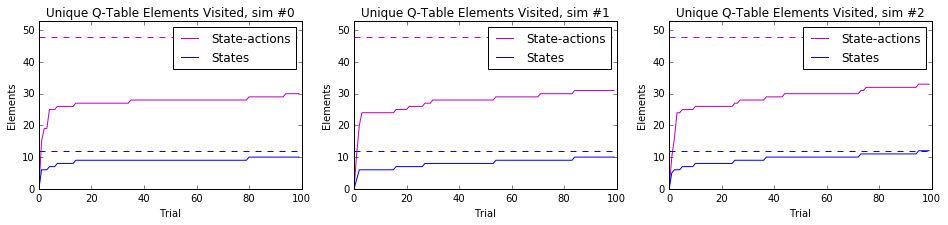

In [18]:
plot_visited_state_actions('48_3s_explore_out.tsv', take=2, legend_loc=1, states=12)

The state-actions to states ratio is good, though it's not perfect yet. As we discussed earlier, it is hard or even impossible for the agent to visit all state-actions during its current life.

We also notice that it takes a very small amount of trials to visit almost all state-actions. After that, the exploration strategy stops helping the agent explore new moves and just forces it to make random decisions thus increasing LRE. When we think about the decay of $\epsilon$ for GLIE, we may use not a decay, but just a step function:

```
def decay_epsilon(self, t):
    if t < threshold: self.epsilon = 1
    else: self.epsilon = 0
```

The best function is just a fusion of total exploration during the first two trials and full exploitation during the rest of the time. If we set the threshold = 1, an exploration policy will be replaced by an exploitation policy by the third trial (we update $\epsilon$ after each trial, so by trial \#0 it is 1 as we assigned, by trial \#1 it is also 1, because 0 < 1).

We face a dilemma: we can either keep a low threshold and get a low LRE. In this case, our agent makes the least amount of mistakes by the end of simulation (100 trials), but in some longer run (say, 10000 trials), such a limited exploration will result in a worse LRE. Vice versa: a high threshold is good for a long run, but for a shorter task (we just have 100 trials, after all) it might be an overkill.

For a 100 trials simulation, this dilemma is below:

```
low threshold                         high threshold
  <---------------------------------------------->
high bias                                   low bias
low LRE                                     high LRE
```

I'd prefer a low threshold: we just have 100 trials, thus require our agent deliver results quickly.

Note that **this function is optimized for a shorter Q-Table**. An agent with a larger Q-Table needs more time to explore the world as we saw earlier in the random walk section; setting $\epsilon$ to 0 after just a handful of trials will terminate any structured learning and result in suboptimal performance. 

Anyway, let's plot errors of our unoptimized function with $\alpha = 0.3, \gamma = 0.7$, 128 states (Q-Table with 12 states will follow). We use a simple greedy strategy:

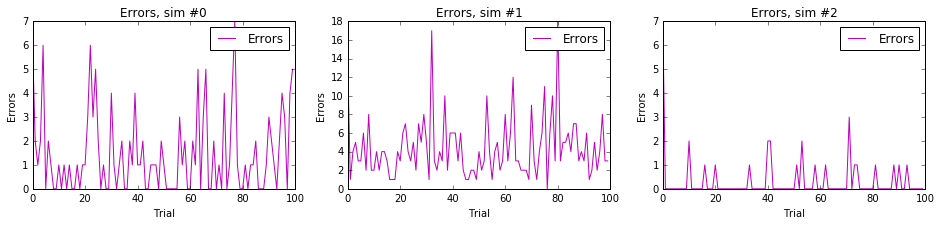

In [32]:
plot_errors('512_greedy_0.3_0.7.tsv')

Now we make the first optimization and switch to GLIE:

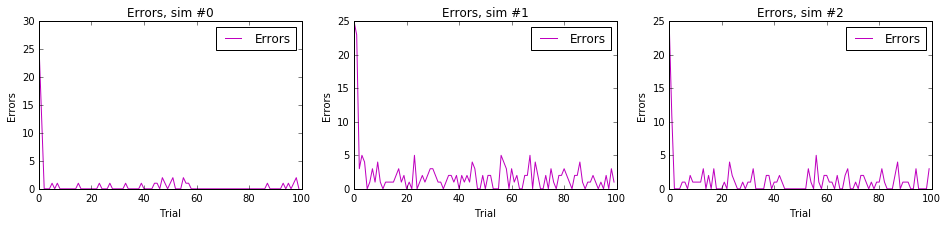

In [33]:
plot_errors('512_glie_basic_0.3_0.7.tsv')

### Hyperparameters tuning

The next step is to optimize the parameters of our Q-Learning model. We currently have two parameters to optimize:

- alpha, the learning rate
- gamma, long-run reward preference or a discount rate.

We can do a sort of a grid search iterating through each combination of parameters. This allows us see how each of them and their combination influence the learning quality.

The metric is LRE, the goal is to find the $argmin_{\alpha,\gamma}[LRE(\alpha,\gamma)]$.

**More considerations:**

\- We use $\epsilon$-greedy strategy, specifically, GLIE (greedy limit + infinite exploration). This is a simple way to solve exploration-exploitation dilemma. 

\- We are not going to decay the learning rate. Adding a decay will make our tuning analysis more complex and will hardly provide any benefits to learning. GLIE makes our agent greedy over time which reduces the potential for learning. Adding another way to force exploitation may result in suboptimal performance.

_**Report the different values for the parameters tuned in your basic implementation of Q-Learning.**_

We need to define LRE function:

In [6]:
# Calculate LRE from one simulation
def lr_errors_s(simulation_errors):
    errors = []
    for t, e in zip(range(0,100), simulation_errors):
         errors.append(tanh(t**2/100) * e)
    return sum(errors)

# Find the average LRE from all simulations in the file
def lre_all_sims(file):
    errors = []
    moves = pd.read_csv(file, sep='\t')
    for sim in set(moves['simulation']):
        moves_sim = moves[moves.simulation == sim]
        errors.append(lr_errors_s(moves_sim['errors']))
    return np.mean(errors)

Now let's create a hyperparams grid, run simulators in parallel and log outputs. This is done for a default Q-Table with 512 items:

In [37]:
# This generates 49 * 2 = 98 log files for a grid search

# Sometimes it may raise I/O exception, in this case just run the rest of the notebook manually
# or delete 512_glie_grid directory and try from this point again

alphas = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
gammas = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]

def run_simulator(vals):
    alpha, gamma = vals

    for sim in range(0,3):
        !python -m smartcab.agent {alpha} {gamma} 1 True default glie > 512_glie_grid/512_{alpha}_{gamma}_raw.txt
        !python log_parser.py 512_glie_grid/512_{alpha}_{gamma}_raw.txt {sim} >> 512_glie_grid/512_{alpha}_{gamma}_data.tsv

pool = ThreadPool(8)

!mkdir 512_glie_grid
pool.map(run_simulator, list(product(alphas, gammas)))

pool.close()

Let's parse the files and calculate LRE for a simulations set in each of the files. As an outcome, we'll have a structure with $\alpha, \gamma$ and LRE. This structure is then converted to a pandas dataframe `grid_errors`.

In [38]:
grid_search = []

for alpha, gamma in product(alphas, gammas):
    file = "512_glie_grid/512_{}_{}_data.tsv".format(alpha, gamma)
    lre = lre_all_sims(file)
    grid_search.append([alpha, gamma, lre])
    
grid_errors = pd.DataFrame(grid_search, columns=['alpha', 'gamma', 'lre'])

Here are the results:

In [39]:
grid_errors

,alpha,gamma,lre
0,0.01,0.01,15.895072
1,0.01,0.10,16.141360
2,0.01,0.25,15.883603
3,0.01,0.50,13.400754
4,0.01,0.75,17.559690
5,0.01,0.90,21.089974
6,0.01,0.99,17.911690
7,0.10,0.01,14.453138
8,0.10,0.10,14.329982
9,0.10,0.25,20.204828


We see a pattern: 
- when $\alpha$ is small, the choice of $\gamma$ doesn't heavily affect the performance of the agent
- the more we increase $\alpha$, the more sensitive LRE becomes to the increase of $\gamma$
- we can still try to compensate high alpha with a low $\gamma$. This idea was explored and resulted in an unreliable agent for some simulations.

The learner with a low alpha seems to be the most reliable. A better idea would be to take several learners with a small LRE and see their percentage of reaching the target. As we know, an agent may become biased and stand still too many times. Such a possibility should be eliminated.

Target reaches less than 98% are considered unsatisfactory: out of 100 trials, the agent is allowed to miss target only twice when it's learning.

Here are tested configurations:
```
alpha   gamma   lre         worst_%_of_target_reach
0.01	0.01	15.895072   96%
0.01	0.10	16.141360   98% (but failed after training trials)
0.01	0.50	13.400754   97%
0.10	0.01	14.453138   97%
0.10	0.10	14.329982   98% (best performance; no errors in the middle of runs)
0.25	0.10	14.723733   98% (but failed after training trials)
0.50	0.10	12.324126   97%
0.99	0.10	13.854868   99% (this one became unreliable after more simulations)
```

_**For which set of parameters does the agent perform best? How well does the final driving agent perform?**_

For our 512 values Q-Table we pick $\alpha=0.1, \gamma=0.1$. We visualize this agent and evaluate its performance:

Goal Reached, sim #0: goal_reached
False    0.02
True     0.98
Name: trial, dtype: float64

Goal Reached, sim #1: goal_reached
False    0.01
True     0.99
Name: trial, dtype: float64

Goal Reached, sim #2: goal_reached
False    0.01
True     0.99
Name: trial, dtype: float64

Goal Reached, avg.: goal_reached
False    0.013333
True     0.986667
Name: trial, dtype: float64


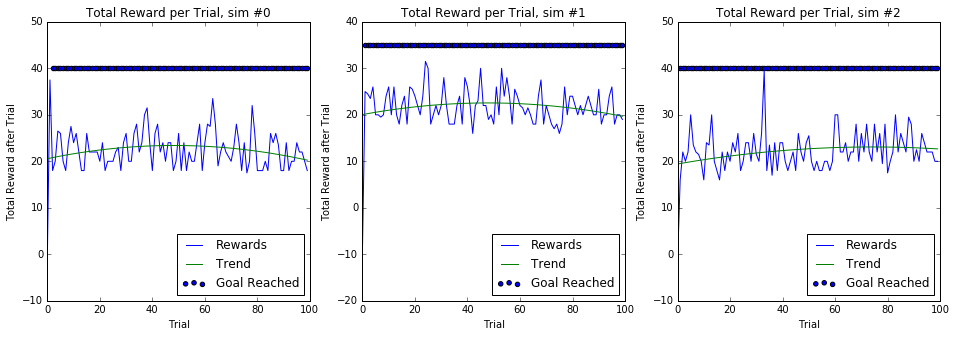

In [20]:
plot_rewards('512_add_runs_0.1_0.1.tsv')

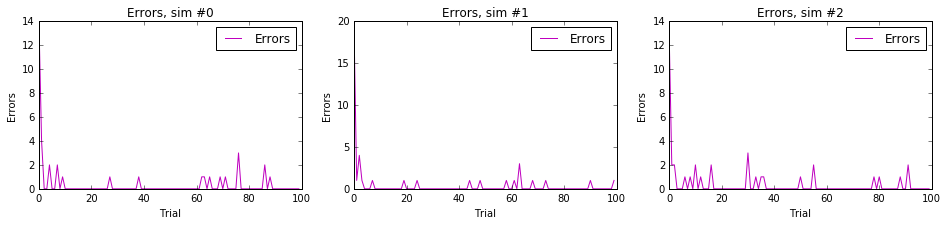

In [19]:
# From now on, I'll use my logs
# If you run a grid search, you can use yours by plotting logs from '512_glie_grid' directory 

plot_errors('512_add_runs_0.1_0.1.tsv')

#### Some considerations about the tradeoffs

We see from the plot above that our agent, though trained well, still makes mistakes. As we discussed, a 512-value Q-Table agent configured to make greedy actions after the second trial, is vulnerable to all the biases we touched upon earlier. These biases can't be removed by simply increasing the threshold (though it would help), nor by changing an action selection strategy: this agent just needs much more time to visit and learn more state-actions.

A very different picture appears when we change Q-Table to a shorter one. Even with a low threshold = 1 we get a nice result:

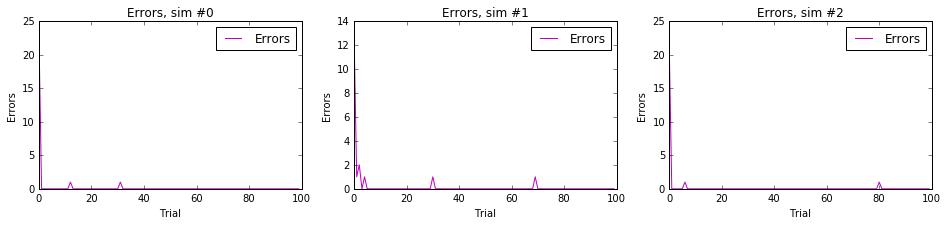

In [31]:
plot_errors("48_glie_add_runs_0.1_0.1.tsv")

Goal reached since trial 2, sim #0: goal_reached
True    1.0
Name: trial, dtype: float64

Goal reached since trial 2, sim #1: goal_reached
True    1.0
Name: trial, dtype: float64

Goal reached since trial 2, sim #2: goal_reached
True    1.0
Name: trial, dtype: float64



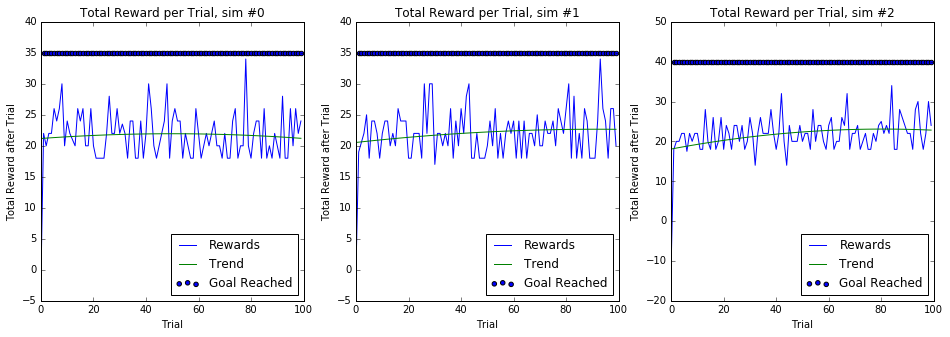

In [25]:
plot_rewards("48_glie_add_runs_0.1_0.1.tsv", start_from_trial=2)

To analyze the performance of this agent, we can take the state of Q-Table at the end of simulation (trial \#100) and make a table with frequent state-actions:

In [21]:
sa_sample = {('forward', 'red', None, None, 'forward'): 3, ('right', 'green', None, None, 'right'): 64, ('left', 'red', None, None, 'None'): 101, ('right', 'red', None, None, 'left'): 1, ('right', 'red', 'left', None, 'right'): 2, ('forward', 'red', 'right', None, 'None'): 1, ('left', 'green', None, 'left', 'left'): 1, ('left', 'red', None, None, 'right'): 1, ('right', 'red', 'forward', None, 'forward'): 1, ('right', 'red', 'left', None, 'None'): 2, ('left', 'red', 'left', None, 'forward'): 1, ('left', 'red', 'left', None, 'right'): 1, ('left', 'green', None, None, 'forward'): 1, ('forward', 'red', 'forward', None, 'right'): 1, ('right', 'green', 'left', None, 'left'): 1, ('forward', 'red', 'left', None, 'left'): 2, ('left', 'red', 'left', None, 'None'): 2, ('right', 'green', None, None, 'None'): 2, ('left', 'red', None, 'left', 'None'): 2, ('right', 'red', 'forward', None, 'left'): 1, ('forward', 'red', None, None, 'None'): 520, ('forward', 'red', 'left', None, 'right'): 1, ('right', 'red', 'left', 'left', 'forward'): 1, ('forward', 'green', None, 'forward', 'forward'): 1, ('forward', 'green', None, 'left', 'None'): 3, ('forward', 'green', None, 'right', 'left'): 1, ('forward', 'green', None, None, 'forward'): 340, ('forward', 'green', 'left', None, 'forward'): 2, ('forward', 'green', 'left', None, 'right'): 1, ('right', 'red', 'forward', None, 'None'): 2, ('left', 'green', None, None, 'right'): 2, ('forward', 'green', 'left', 'forward', 'forward'): 1, ('right', 'green', 'left', None, 'right'): 2, ('forward', 'red', None, None, 'right'): 1, ('left', 'red', None, None, 'forward'): 2, ('left', 'green', None, 'forward', 'forward'): 1, ('left', 'green', None, None, 'left'): 56, ('forward', 'red', 'left', None, 'None'): 2, ('right', 'red', 'left', None, 'forward'): 1, ('forward', 'green', None, 'right', 'None'): 1, ('forward', 'green', 'left', None, 'left'): 1, ('forward', 'green', 'left', None, 'None'): 6, ('forward', 'green', None, 'left', 'forward'): 5, ('forward', 'red', 'right', None, 'left'): 1, ('forward', 'red', None, None, 'left'): 1, ('right', 'red', None, None, 'None'): 1, ('left', 'red', None, None, 'left'): 2, ('left', 'green', None, 'forward', 'None'): 1, ('right', 'red', None, None, 'right'): 65, ('forward', 'red', 'left', None, 'forward'): 1, ('right', 'green', None, None, 'forward'): 2, ('right', 'green', 'forward', None, 'forward'): 1, ('forward', 'green', 'right', None, 'forward'): 2, ('forward', 'red', None, 'left', 'forward'): 1, ('right', 'green', 'left', None, 'None'): 1}

In [22]:
df = pd.DataFrame(map(lambda x: list(x[0]) + [x[1]], sa_sample.items()), columns=['waypoint', 'light', 'oncoming_traffic', 'left_traffic', 'action', 'count'])

df.sort_values('count', ascending=False).head(7)

,waypoint,light,oncoming_traffic,left_traffic,action,count
34,forward,red,None,None,None,520
13,forward,green,None,None,forward,340
22,left,red,None,None,None,101
48,right,red,None,None,right,65
9,right,green,None,None,right,64
15,left,green,None,None,left,56
43,forward,green,left,None,None,6


There are six frequent state-actions, the seventh is added to show a difference in a magnitude between them. As we see, all the actions seem to be reasonable.

In [33]:
lre_all_sims("48_glie_add_runs_0.1_0.1.tsv")

1.5871980316786154

LRE is 9 times better than the one for Q-Table with 512 values. Goal reach is 99%, problems with learning are few and hard to notice.

#### Reviewing the mistakes

There are only 7 mistakes (excluding the first two exploration trials) in 3 simulations. Because the agent makes few mistakes, it does follow the planner, thus, chooses an optimal route. I also analyzed `data.txt`, the initial log file with states and actions logs.

For this configuration (GLIE, Q-Table=48, threshold=1, alpha=gamma=0.1), I found the following. When our smartcab makes a mistake, it's mostly due to unknown state visited. E.g., `('forward', 'red_yield')` was considered a rare state in one simulation and the agent incorrectly decided to move `right`. Another such example is `('left', 'red_yield')`: `forward` was chosen. Both states were visited only once.

I found one very specific problem with this agent: inability to turn right on a red light when it's safe to move:
```
Logger_QTable_State: ('right', 'red_safe_to_move_right')
Logger_QTable_Action: None
Logger_QTable_SA {'forward': -0.271, 'right': 0, None: 0.00502808893284316, 'left': -0.1}
```

This situation occurs when the agent doesn't manage to explore the correct action (`right`) in time (within 2 trials). `None` provides a very small, but positive, reward and it'll be chosen every time in this state. Such a situation was infrequent, but annoying. To solve this problem, we ask the agent (when in exploration mode) to check unknown actions first:

```
if random.random() > self.epsilon:
    best_action = max(actions, key=itemgetter(1))[0]
else:
    zeroed_actions = [k for k,v in actions if v == 0]
    if zeroed_actions: best_action = zeroed_actions[0]
    else: best_action = random.choice(actions)[0]
```

This update worked well, and I found only one remaining source of failures: a coincidence of one wrong action (a rare state visited) and a bad road situation afterwards. There were also several cases when:

```
Environment.act(): Primary agent has reached destination!
LearningAgent.update(): deadline = 0, inputs = {'light': 'green', 'oncoming': None, 'right': None, 'left': None}, action = forward, reward = 12.0
Environment.step(): Primary agent ran out of time! Trial aborted.
```
the agent reached the target just in time, but the logs provided a controversial description.

_**Does your agent get close to finding an optimal policy, i.e. reach the destination in the minimum possible time, and not incur any penalties? How would you describe an optimal policy for this problem?**_

I suppose, the agent gets an acceptable score for reaching targets in time and making correct moves. This is especially true for the agent with a smaller, 48 state-actions, Q-Table. It basically makes a two or three mistakes per simulation (excluding first two runs when it explores the world).

An optimal policy has already been touched upon in this project. The agent should make a decision:

- Make a move according to the planner if traffic conditions allow it;
- Make no move only if it's forbidden by traffic conditions during this time.

As we saw from plots and logs, our agent approaches this optimal policy in the long run. It won't reach this policy during 100 trials (it needs more time to visit all the states), but the agent makes it close enough. If we'd had infinite time for learning, I'd have made less greedy action selection strategy.

### Considerations about an action selection strategy

We've got some good results using the GLIE action selection. Though good, our results can be improved. For example, when our agent picks an action in exploration mode, it does this randomly. This means that it is just as likely to choose the worst appearing action as it is to choose the next-to-best. 

A workable strategy could be to act optimistically towards unknown state-actions or to choose a different action policy. We can choose among many, one of such strategies is a *softmax action selection*.

Instead of setting $\epsilon$, in softmax action selection, there is a parameter $\tau$, or the temperature. High temperatures cause the actions to be all (nearly) equi-probable. Low temperatures cause a greater difference in selection probability for actions that differ in their value estimates. When $\tau$ gets close to 0, softmax action selection becomes the same as greedy action selection [[Sutton, 1997](https://webdocs.cs.ualberta.ca/~sutton/book/2/node4.html)].

We won't compare GLIE to softmax formally, because it is not in the scope of this project, but it's possible to run the simulation using softmax. To do so, change `self.action_policy = 'softmax'` in the initialization of `LearningAgent`.

Frankly speaking, I didn't see any significant changes in learning when I tried softmax. In the first trials this strategy showed more errors, but in the long run the results were comparable.

A good idea may be to run a grid search with different values of $\alpha, \gamma, \tau$. I ran it for a shorter Q-Table with a constant value of $\tau$ (no decay) and found the best combination $\alpha=0.99, \gamma=0.01, \tau=0.1$. LRE = 5.58, goal reach was perfect (100%) for two simulations and there was only one failure (99% success percentage) to reach the goal in the other one. It's worth noticing that all good combinations included high values of $\alpha$ and small values of $\tau$.

## Wrapping it up

To sum up, we found a good action selection policy: GLIE, constant learning rate, $\alpha=0.1, \gamma=0.1$, Q-Table with 48 state-action pairs, LRE = 1.59, 99% successful goal reaches.

While implementing Q-Learning, there is a number of points to consider:

- What action selection strategy to choose. GLIE is a good default strategy, but it allows an agent to act randomly. In case of a dangerous world (some actions are extremely penalized) we may prefer a softmax action selection.

- How to minimize Q-Table: a smaller Q-Table dramatically improves the performance of an agent.

- How to optimize parameters of the model. Grid search is a good option if we are allowed to run simulations infinite amount of times without any costs involved.

- A function for decaying $\epsilon$, $\tau$ or $\alpha$. I tried different functions manually, but there may be a better way for this.